# 09: Train on Downloaded Nightlight Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from PIL import Image
import gc
import pandas as pd

## Data Set-up

In [2]:
test_image = Image.open('../data/training/class1/lat_-0.3329_lon_10.3832_2000.jpg')
test_image.size

(430, 433)

In [2]:
# get mean and std of image
transform = transforms.Compose(
            [transforms.Resize(size=(430, 430)),
             transforms.Grayscale(1),
             transforms.ToTensor()
             ]
        )
trainset = torchvision.datasets.ImageFolder(root = '../data/training', transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset))
loader_iter = iter(trainloader)
images, _ = loader_iter.next()
image_mean = images.mean()
image_std = images.std()


In [15]:
image_mean

tensor(0.0277)

In [16]:
image_std

tensor(0.0504)

In [3]:
# Augment Images

# original
transform = transforms.Compose(
    [transforms.Resize(size = (430, 430)),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize(image_mean, image_std)
     ]
)

# rotated
transform_rotation = transforms.Compose(
    [transforms.Resize(size = (430, 430)),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize(image_mean, image_std),
     transforms.RandomRotation(180)
     ]
)

# horizontally flipped
transform_fliph = transforms.Compose(
    [transforms.Resize(size = (430, 430)),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize(image_mean, image_std),
     transforms.RandomHorizontalFlip(1)
     ]
)

# vertically flipped
transform_flipv = transforms.Compose(
    [transforms.Resize(size = (430, 430)),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize(image_mean, image_std),
     transforms.RandomVerticalFlip(1)
     ]
)

trainset = torchvision.datasets.ImageFolder(root = '../data/training', transform = transform)

trainset_rotated = torchvision.datasets.ImageFolder(root = '../data/training', transform = transform_rotation)

trainset_fliph = torchvision.datasets.ImageFolder(root = '../data/training', transform = transform_fliph)

trainset_flipv = torchvision.datasets.ImageFolder(root = '../data/training', transform = transform_flipv)

all_training = torch.utils.data.ConcatDataset([trainset, trainset_rotated, trainset_fliph, trainset_flipv])

devset = torchvision.datasets.ImageFolder(root = '../data/dev', transform = transform)

In [4]:
trainloader = torch.utils.data.DataLoader(all_training, batch_size=50,
                                          shuffle = True, num_workers=2)

devloader = torch.utils.data.DataLoader(devset, batch_size=50, shuffle=False, num_workers=2)

labels = ['class1', 'class2', 'class3', 'class4', 'class5']

### Some initial plots

In [17]:
dataiter = iter(trainloader)
images, label = dataiter.next()

In [18]:
images.shape

torch.Size([50, 1, 430, 430])

Label:  tensor(0)


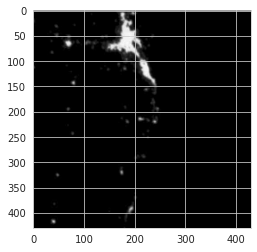

In [63]:
print("Label: ", label[0])
plt.imshow((images[0].numpy().squeeze()) / 2 + 0.5, cmap = 'gray')

Label:  tensor(3)


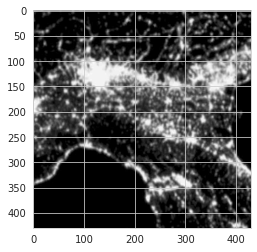

In [64]:
print("Label: ", label[1])
plt.imshow((images[1].numpy().squeeze()) / 2 + 0.5, cmap = 'gray')

Label:  tensor(4)


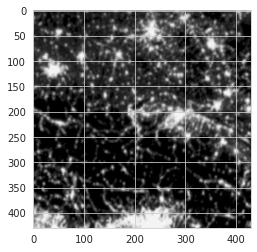

In [65]:
print("Label: ", label[2])
plt.imshow((images[2].numpy().squeeze()) / 2 + 0.5, cmap = 'gray')

Label:  tensor(0)


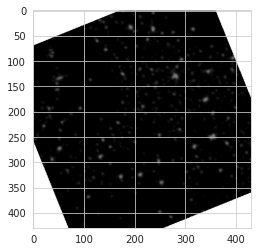

In [66]:
print("Label: ", label[3])
plt.imshow((images[3].numpy().squeeze()) / 2 + 0.5, cmap = 'gray')

## Create a Baseline
- Just a very simple baseline - add all the pixels in the image and explore with Gaussian Naive Bayes and Multinomial Logistic Regression

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [6]:
baselineloader = torch.utils.data.DataLoader(all_training, batch_size=len(all_training))
loader_iter = iter(baselineloader)
images, labels = loader_iter.next()

In [9]:
pixel_sums = torch.sum(images, dim=[1, 2, 3])

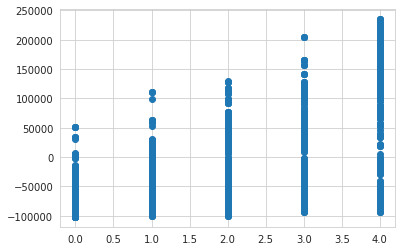

In [10]:
plt.scatter(labels, pixel_sums)
plt.show()

In [11]:
pixel_sum_df = pd.DataFrame({'class': labels,
                             'pixel_sum': pixel_sums})
pixel_sum_df.head()

,class,pixel_sum
0,0,-91516.562500
1,0,-92669.265625
2,0,-92537.460938
3,0,-101822.625000
4,0,-101652.210938


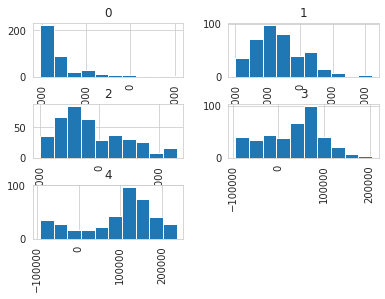

In [12]:
fig = pixel_sum_df.hist('pixel_sum', by='class', bins=10);

Classes don't entirely look Gaussian, but we can continue this for now.

### Fit Models

In [13]:
clfGNB = GaussianNB()
clfGNB.fit(pixel_sums.reshape(-1, 1), labels)

clf_MLR = LogisticRegression()
clf_MLR.fit(pixel_sums.reshape(-1, 1), labels)

LogisticRegression()

In [14]:
import pickle
pickle.dump(clfGNB, open('../results/gnb_model.sav', 'wb'))

In [62]:
# get devset pixelsums
devloader_all = torch.utils.data.DataLoader(devset, batch_size=len(devset))
loader_iter = iter(devloader_all)
images_dev, labels_dev = loader_iter.next()
pixel_sum_dev = torch.sum(images_dev, dim=[1, 2, 3])
pixel_sum_dev = pixel_sum_dev.reshape(-1, 1)

In [63]:
predictions_GNB = clfGNB.predict(pixel_sum_dev)
predictions_MLR = clf_MLR.predict(pixel_sum_dev)

In [64]:
correct_GNB = labels_dev.numpy() == predictions_GNB
correct_MLR = labels_dev.numpy() == predictions_MLR

In [65]:
print('Correct classification with Gaussian Naive Bayes: ', 100 * sum(correct_GNB)/len(correct_GNB), '%')
print('Correct classification with Multinomial Logistic Regression: ', 100 * sum(correct_MLR)/len(correct_MLR), '%')

Correct classification with Gaussian Naive Bayes:  48.0 %
Correct classification with Multinomial Logistic Regression:  38.0 %


## Initial CNN

In [18]:
# calculate layer size CNNs
img_size = 430
kernel_size = 5
padding = 0
stride = 1

def get_conv_size(features, padding, kernel_size, stride):
    return np.floor((features + 2 * padding - kernel_size) / stride) + 1

c1 = get_conv_size(img_size, padding, kernel_size, stride)
pool_dim = c1 / 2
c2 = get_conv_size(pool_dim, padding, kernel_size, stride)
pool_dim2 = np.floor(c2/2)
c3 = get_conv_size(pool_dim2, padding, kernel_size, stride)
c4 = get_conv_size(np.floor(c3/2),  padding, kernel_size, stride)
c5 = get_conv_size(np.floor(c4/2), padding, kernel_size, stride)

print('c1:', c1)
print('pool_dim:', pool_dim)
print('c2:', c2)
print('pool_dim2:', pool_dim2)
print('c5: ', c5)
print('c5 after pooling', np.floor(c5/2))

c1: 426.0
pool_dim: 213.0
c2: 209.0
pool_dim2: 104.0
c5:  19.0
c5 after pooling 9.0


In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 5)
        self.conv4 = nn.Conv2d(32, 64, kernel_size = 5)
        self.conv5 = nn.Conv2d(64, 128, kernel_size = 5)
        self.fc1 = nn.Linear(128 * 9 * 9, 120) # channels * dims of last conv NN
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
torch.cuda.is_available()

True

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [22]:
# try training on GPU
gc.collect()
torch.cuda.empty_cache()
net_gpu = Net().to(device)
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_gpu.parameters(), lr = 0.001)



In [24]:
start_time = time.time()
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_gpu(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every 2mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0

end_time = time.time()
print('Finished Training')

total_time_gpu = end_time - start_time

[1,     2] loss: 1.014
[1,     4] loss: 0.751
[1,     6] loss: 0.714
[1,     8] loss: 0.846
[1,    10] loss: 1.149
[1,    12] loss: 0.808
[1,    14] loss: 0.915
[1,    16] loss: 1.014
[1,    18] loss: 0.957
[1,    20] loss: 0.904
[1,    22] loss: 1.032
[1,    24] loss: 0.847
[1,    26] loss: 0.919
[1,    28] loss: 1.012
[1,    30] loss: 0.910
[1,    32] loss: 0.878
[1,    34] loss: 0.762
[1,    36] loss: 0.940
[1,    38] loss: 0.913
[1,    40] loss: 0.746
[2,     2] loss: 0.990
[2,     4] loss: 0.717
[2,     6] loss: 0.761
[2,     8] loss: 0.735
[2,    10] loss: 0.754
[2,    12] loss: 0.580
[2,    14] loss: 0.761
[2,    16] loss: 0.784
[2,    18] loss: 0.791
[2,    20] loss: 0.578
[2,    22] loss: 0.683
[2,    24] loss: 0.682
[2,    26] loss: 0.645
[2,    28] loss: 0.757
[2,    30] loss: 0.521
[2,    32] loss: 0.732
[2,    34] loss: 0.791
[2,    36] loss: 0.850
[2,    38] loss: 0.858
[2,    40] loss: 0.688
[3,     2] loss: 0.633
[3,     4] loss: 0.799
[3,     6] loss: 0.637
[3,     8] 

In [25]:
total_time_gpu/60

2.35210098028183

In [26]:
torch.save(net_gpu.state_dict(), '../results/lights_inital2.pth')

## Test on dev set

In [27]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in devloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net_gpu(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 50 test images: 92 %


Yay, that looks good!

Some learnings:

- My model didn't start learning until after I augmented my images (adding rotations, flipped images), so I'm guessing I didn't have enough data at first my model to be able to learn.
- I made some edits to the above after changing over to pytorch-lightning. I was able to debug my model further using pytorch-lightning and realized I was not normalizing my image correctly. Upon fixing that, training started happening much faster.
- I also found that there is ~ 6x difference in speed of running on GPU vs. CPU.
- I at first thought that classifying populations from night lights might be too easy - that the total brightness (adding all the pixels in the image) would correspond to the population. It turns out that there seemed to be a lot of spread in each class and the Gaussian Naive Bayes baseline model was ~50% accurate. It's great to see that adding the spatial connections from CNN improves the classification percentage.

## Running with pytorch-lightning

I've wanted to try out this workflow!

In [5]:
from scripts.models import *

In [6]:
# model
encoder = LitModel(CNN())

# train model
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=20, accelerator='gpu', devices=1)
trainer.fit(model = encoder, train_dataloaders=trainloader, val_dataloaders= devloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | encoder | CNN  | 1.5 M 
---------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.109     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mnakajim/anaconda3/envs/NightLights/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mnakajim/anaconda3/envs/NightLights/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
/home/mnakajim/anaconda3/envs/NightLights/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [8]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...